## KNN Implementation on scaled reduced dataset with t-SNE

In [1]:
# Utilities
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt

# Models
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, accuracy_score, f1_score
from sklearn.metrics import classification_report, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
seed = 23

In [21]:
df_train = pd.read_csv('X_train_SVD.csv')

In [22]:
df_test = pd.read_csv('X_test_SVD.csv')

In [5]:
print(df_train.columns)

Index(['Dimension 1', 'Dimension 2'], dtype='object')


In [23]:
df_scaled = pd.read_csv('dataset_preprocessed.csv')

In [10]:
print(df_scaled.columns)

Index(['releaseYear', 'runtimeMinutes', 'lifetimeGross', 'nrOfReleases',
       'director_nrOfMovies', 'nrOfEmployees', 'nrOfActors', 'averageRating',
       'numVotes', 'sameYearTotalMoviesReleased', 'Action', 'Adventure',
       'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Musical', 'Mystery',
       'Other', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western'],
      dtype='object')


In [6]:
df_train.head()

,Dimension 1,Dimension 2
0,1.103460,0.072267
1,1.461354,-0.592586
2,1.647283,0.088656
3,1.676719,-0.541218
4,1.570116,-0.572993


In [7]:
df_test.head()

,Dimension 1,Dimension 2
0,1.220573,0.206269
1,1.250327,-0.570413
2,1.368459,-0.546002
3,1.277790,0.761160
4,1.636357,0.070829


In [34]:
#df_scaled_sample = df_scaled.sample(n=1000, random_state=seed)
df_scaled_sample = df_scaled

In [24]:
labels = df_scaled['averageRating']
_, _, y_train, y_test = train_test_split(df_scaled.drop(columns=['averageRating']), labels, test_size=0.2, random_state=42)

In [13]:
# df_train['averageRating'] = y_train.reset_index(drop=True)
# df_test['averageRating'] = y_test.reset_index(drop=True)

In [10]:
# test_size = 0.2
# X_train, X_test, y_train, y_test = train_test_split(
#     df_scaled_sample.drop('averageRating', axis=1),
#     df_scaled_sample['averageRating'], test_size=test_size,
#     random_state=seed
# )

In [14]:
def calculate_metrics(model_name, y_true, y_pred):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Weighted F1': f1_score(y_true, y_pred, average='weighted'),
        'Weighted Precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'Weighted Recall': recall_score(y_true, y_pred, average='weighted'),
        'Macro-Averaged Precision': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'Macro-Averaged Recall': recall_score(y_true, y_pred, average='macro'),
        'F1': str(f1_score(y_true, y_pred, average=None)),
        'Precision': str( precision_score(y_true, y_pred, average=None, zero_division=0)),
    }

    # Print the metrics
    print(f"Metrics for {model_name}:")
    for metric_name, metric_value in metrics.items():
        try:
            print(f"{metric_name}: {metric_value:.4f}")
        except:
            print(f"{metric_name}: {metric_value}")

    # Print the classification report
    print("classification report")
    report = classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1'], zero_division=0)
    print(report)

    print("Confusion Matrix")
    cm = confusion_matrix(y_true, y_pred)
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
    cmd.plot()

    plt.title(f'Confusion matrix for model {model_name} (Accuracy:{metrics["Accuracy"]:.4f})')
    plt.show()

    # Create df to store metrics
    df_metrics = pd.DataFrame(metrics, index=[model_name])

    return df_metrics

In [25]:
# # Replace negative values with 0.0
df_train = df_train.clip(lower=0)
df_test = df_test.clip(lower=0)

df_train.fillna(0.0, inplace=True)
df_test.fillna(0.0, inplace=True)
model = MultinomialNB()
model.fit(df_train, y_train)

predictions = model.predict(df_test)
print("Accuracy:", accuracy_score(y_test, predictions))

print("F1 score:", f1_score(y_test, predictions, average=None))

Accuracy: 0.5586275816122585
F1 score: [0.4925316  0.60949013]


In [26]:
param_grid = {
    'alpha' : [0.5, 0.75, 1.0],
    'fit_prior' : [True, False]
}

model = MultinomialNB()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(df_train, y_train)

print("The parameters with the highest score: ", grid_search.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
The parameters with the highest score:  {'alpha': 0.75, 'fit_prior': False}


In [29]:
cv_results_df = pd.DataFrame(grid_search.cv_results_)

# Show top 10 parameters for this model
minimalistic_results = cv_results_df[['params', 'mean_test_score']]
sorted_results = minimalistic_results.sort_values(by='mean_test_score', ascending=False)

print(sorted_results.head(10))

                                params  mean_test_score
3  {'alpha': 0.75, 'fit_prior': False}         0.568846
5   {'alpha': 1.0, 'fit_prior': False}         0.568846
1   {'alpha': 0.5, 'fit_prior': False}         0.568679
0    {'alpha': 0.5, 'fit_prior': True}         0.557017
2   {'alpha': 0.75, 'fit_prior': True}         0.556934
4    {'alpha': 1.0, 'fit_prior': True}         0.556934


Metrics for MNB-SVD-GS-CV1:
Accuracy: 0.4957
Weighted F1: 0.4808
Weighted Precision: 0.4964
Weighted Recall: 0.4957
Macro-Averaged Precision: 0.4964
Macro-Averaged Recall: 0.4968
F1: [0.39536741 0.56742857]
Precision: [0.49848943 0.49427576]
classification report
              precision    recall  f1-score   support

     Class 0       0.50      0.33      0.40      1511
     Class 1       0.49      0.67      0.57      1491

    accuracy                           0.50      3002
   macro avg       0.50      0.50      0.48      3002
weighted avg       0.50      0.50      0.48      3002

Confusion Matrix


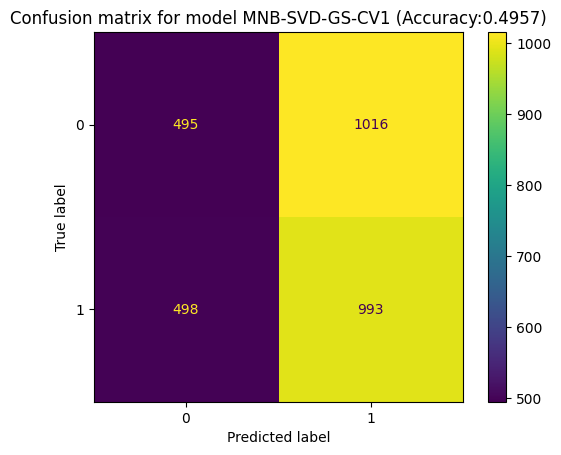

In [37]:
best_model = grid_search.best_estimator_
predictions = best_model.predict(df_test)
_ = calculate_metrics('MNB-SVD-GS-CV1', y_test, predictions)

In [30]:
# Predicting using other alternatives of fine-tuning from top 10 performances
other_alternatives = []
# Choose a set of parameters from sorted_results
for i in range(5):

  params = sorted_results.iloc[i]['params']
  print("Parameters from place: ", i, " ", params)

  model = MultinomialNB(**params)
  model.fit(df_train, y_train)

  predictions = model.predict(df_test)

  chosen_accuracy = accuracy_score(y_test, predictions)
  print("Accuracy for chosen parameters:", chosen_accuracy)
  other_alternatives.append((chosen_accuracy,params))


Parameters from place:  0   {'alpha': 0.75, 'fit_prior': False}
Accuracy for chosen parameters: 0.569620253164557
Parameters from place:  1   {'alpha': 1.0, 'fit_prior': False}
Accuracy for chosen parameters: 0.569620253164557
Parameters from place:  2   {'alpha': 0.5, 'fit_prior': False}
Accuracy for chosen parameters: 0.569620253164557
Parameters from place:  3   {'alpha': 0.5, 'fit_prior': True}
Accuracy for chosen parameters: 0.5586275816122585
Parameters from place:  4   {'alpha': 0.75, 'fit_prior': True}
Accuracy for chosen parameters: 0.5586275816122585


In [31]:
# get best from top 10
best_tuple = max(other_alternatives, key=lambda x: x[0])

In [32]:
print("Best accuracy and parameters after running the algorithm using other alternatives of fine tuning from top 10 performances")
print(best_tuple[0])
print(best_tuple[1])

Best accuracy and parameters after running the algorithm using other alternatives of fine tuning from top 10 performances
0.569620253164557
{'alpha': 0.75, 'fit_prior': False}


In [33]:
# Run on training sample

# Choose a set of parameters from sorted_results
for i in range(5):

  params = sorted_results.iloc[i]['params']
  print("Parameters from place: ", i, " ", params)

  model = MultinomialNB(**params)
  model.fit(df_train, y_train)

  predictions = model.predict(df_train)

  chosen_accuracy = accuracy_score(y_train, predictions)
  print("Accuracy for chosen parameters:", chosen_accuracy)

Parameters from place:  0   {'alpha': 0.75, 'fit_prior': False}
Accuracy for chosen parameters: 0.5676801332778009
Parameters from place:  1   {'alpha': 1.0, 'fit_prior': False}
Accuracy for chosen parameters: 0.5676801332778009
Parameters from place:  2   {'alpha': 0.5, 'fit_prior': False}
Accuracy for chosen parameters: 0.5675968346522282
Parameters from place:  3   {'alpha': 0.5, 'fit_prior': True}
Accuracy for chosen parameters: 0.5576009995835068
Parameters from place:  4   {'alpha': 0.75, 'fit_prior': True}
Accuracy for chosen parameters: 0.5575177009579342


In [35]:
best_accuracy = 0
best_report = None
best_predictions = None
y_best_predictions = None
all_reports = []

for i in range(100):
  random_state_fit = np.random.randint(1000)

  test_size = 0.2
  X_train, X_test, y_train, y_test = train_test_split(
    df_scaled_sample.drop('averageRating', axis=1),
    df_scaled_sample['averageRating'], test_size=test_size,
    random_state=random_state_fit)

  X_train.fillna(0.0, inplace=True)
  y_train.fillna(0.0, inplace=True)
  y_test.fillna(0.0, inplace=True)
  X_train = X_train.clip(lower=0)
  X_test = X_test.clip(lower=0)

  model = MultinomialNB(**best_tuple[1])
  model.fit(X_train, y_train)

  predictions = model.predict(X_test)
  current_accuracy = accuracy_score(y_test, predictions)

  report = classification_report(y_test, predictions, output_dict=True, zero_division=0)
  all_reports.append(report)
  print(current_accuracy)

  if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy
        best_report = report
        best_predictions = predictions
        y_best_predictions = y_test

def average_classification_report(reports):
    metrics = ['precision', 'recall', 'f1-score']
    avg_report = {}
    for metric in metrics:
        avg_report[metric] = sum(r['macro avg'][metric] for r in reports) / len(reports)
    avg_report['accuracy'] = sum(r['accuracy'] for r in reports) / len(reports)
    return avg_report

avg_report = average_classification_report(all_reports)

print("Best Classification Report:")
print(classification_report(y_best_predictions, best_predictions, zero_division=0))
print("Best Accuracy:", best_accuracy)
print()
print("Average Classification Report:")
for metric, score in avg_report.items():
    print(f"{metric}: {score:.4f}")

0.6708860759493671
0.6772151898734177
0.6655562958027982
0.6755496335776149
0.6748834110592938
0.6658894070619586
0.6722185209860093
0.6718854097268487
0.6712191872085277
0.6775483011325782
0.6632245169886742
0.6635576282478348
0.6748834110592938
0.6618920719520319
0.6772151898734177
0.6725516322451699
0.6618920719520319
0.6718854097268487
0.6705529646902065
0.6728847435043305
0.67854763491006
0.6752165223184544
0.6868754163890739
0.6825449700199867
0.6668887408394404
0.6728847435043305
0.6508994003997335
0.656562291805463
0.6748834110592938
0.6658894070619586
0.6942038640906063
0.667221852098601
0.6768820786142572
0.6618920719520319
0.6725516322451699
0.6822118587608261
0.676215856095936
0.6685542971352432
0.6772151898734177
0.6885409726848768
0.656562291805463
0.6855429713524317
0.6635576282478348
0.679213857428381
0.664890073284477
0.6698867421718854
0.6665556295802798
0.6712191872085277
0.6595602931379081
0.6698867421718854
0.6705529646902065
0.6705529646902065
0.6758827448367755
0

Metrics for MNB-SVD-Shuffled_best:
Accuracy: 0.6942
Weighted F1: 0.6900
Weighted Precision: 0.6988
Weighted Recall: 0.6942
Macro-Averaged Precision: 0.6999
Macro-Averaged Recall: 0.6890
F1: [0.73236152 0.64335664]
Precision: [0.67599569 0.72377622]
classification report
              precision    recall  f1-score   support

     Class 0       0.68      0.80      0.73      1572
     Class 1       0.72      0.58      0.64      1430

    accuracy                           0.69      3002
   macro avg       0.70      0.69      0.69      3002
weighted avg       0.70      0.69      0.69      3002

Confusion Matrix


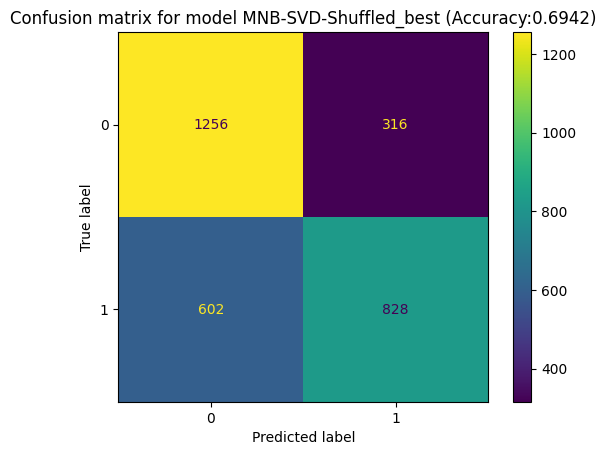

,Accuracy,Weighted F1,Weighted Precision,Weighted Recall,Macro-Averaged Precision,Macro-Averaged Recall,F1,Precision
MNB-SVD-Shuffled_best,0.694204,0.689964,0.698756,0.694204,0.699886,0.689002,[0.73236152 0.64335664],[0.67599569 0.72377622]


In [38]:
calculate_metrics('MNB-SVD-Shuffled_best', y_best_predictions, best_predictions)